### 5.1 Grid Search Optimizer

In [1]:
# load path
import sys
if "src/" not in sys.path:
    sys.path.append("src/")

from pypm import metrics, signals, data_io, simulation

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict, OrderedDict
from itertools import product
from timeit import default_timer
from typing import Dict, Tuple, List, Callable, Iterable, Any, NewType, Mapping

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 

In [4]:
# Performance data and parameter inputs are dictionaries
Parameters = NewType('Parameters', Dict[str, float])
Performance = simulation.PortfolioHistory.PerformancePayload # Dict[str, float]

In [5]:
# Simulation function must take parameters as keyword arguments pointing to 
# iterables and return a performance metric dictionary
SimKwargs = NewType('Kwargs', Mapping[str, Iterable[Any]])
SimFunction = NewType('SimFunction', Callable[[SimKwargs], Performance])

In [6]:
class OptimizationResult(object):
    """Simple container class for optimization data"""

    def __init__(self, parameters: Parameters, performance: Performance):

        # Make sure no collisions between performance metrics and params
        assert len(parameters.keys() & performance.keys()) == 0, \
            'parameter name matches performance metric name'

        self.parameters = parameters
        self.performance = performance

    @property
    def as_dict(self) -> Dict[str, float]:
        """Combines the dictionaries after we are sure of no collisions"""
        return {**self.parameters, **self.performance}

In [7]:
class GridSearchOptimizer(object):
    """
    A generic grid search optimizer that requires only a simulation function and
    a series of parameter ranges. Provides timing, summary, and plotting 
    utilities with return data.
    """

    def __init__(self, simulation_function: SimFunction):

        self.simulate = simulation_function
        self._results_list: List[OptimizationResult] = list()
        self._results_df = pd.DataFrame()

        self._optimization_finished = False

    def add_results(self, parameters: Parameters, performance: Performance):
        _results = OptimizationResult(parameters, performance)
        self._results_list.append(_results)

    def optimize(self, **optimization_ranges: SimKwargs):

        assert optimization_ranges, 'Must provide non-empty parameters.'

        # Convert all iterables to lists
        param_ranges = {k: list(v) for k, v in optimization_ranges.items()}
        self.param_names = param_names = list(param_ranges.keys())

        # Count total simulation
        n = total_simulations = np.prod([len(r) for r in param_ranges.values()])

        total_time_elapsed = 0

        print(f'Starting simulation ...')
        print(f'Simulating 1 / {n} ...', end='\r')
        for i, params in enumerate(product(*param_ranges.values())):
            if i > 0:
                _avg = avg_time = total_time_elapsed / i
                _rem = remaining_time = (n - (i + 1)) * avg_time
                s =  f'Simulating {i+1} / {n} ... '
                s += f'{_rem:.0f}s remaining ({_avg:.1f}s avg)'
                s += ' '*8
                print(s, end='\r')

            timer_start = default_timer()

            parameters = {n: param for n, param in zip(param_names, params)}
            results = self.simulate(**parameters)
            self.add_results(parameters, results)

            timer_end = default_timer()
            total_time_elapsed += timer_end - timer_start 

        print(f'Simulated {total_simulations} / {total_simulations} ...')
        print(f'Elapsed time: {total_time_elapsed:.0f}s')
        print(f'Done.')

        self._optimization_finished = True

    def _assert_finished(self):
        assert self._optimization_finished, \
            'Run self.optimize before accessing this method.'

    @property
    def results(self) -> pd.DataFrame:
        self._assert_finished()
        if self._results_df.empty:

            _results_list = self._results_list
            self._results_df = pd.DataFrame([r.as_dict for r in _results_list])

            _columns = set(list(self._results_df.columns.values))
            _params = set(self.param_names)
            self.metric_names = list(_columns - _params)

        return self._results_df

    def print_summary(self):
        df = self.results
        metric_names = self.metric_names

        print('Summary statistics')
        print(df[metric_names].describe().T)

    def get_best(self, metric_name: str) -> pd.DataFrame:
        """
        Sort the results by a specific performance metric
        """
        self._assert_finished()

        results = self.results
        param_names = self.param_names
        metric_names = self.metric_names

        assert metric_name in metric_names, 'Not a performance metric'
        partial_df = self.results[param_names+[metric_name]]

        return partial_df.sort_values(metric_name, ascending=False)

    def plot_1d_hist(self, x, show=True):
        self.results.hist(x)
        if show:
            plt.show()

    def plot_2d_line(self, x, y, show=True, **filter_kwargs):
        _results = self.results
        for k, v in filter_kwargs.items():
            _results = _results[getattr(_results, k) == v]

        ax = _results.plot(x, y)
        if filter_kwargs:
            k_str = ', '.join([f'{k}={v}' for k,v in filter_kwargs.items()])
            ax.legend([f'{x} ({k_str})'])

        if show:
            plt.show()

    def plot_2d_violin(self, x, y, show=True):
        """
        Group y along x then plot violin charts
        """
        x_values = self.results[x].unique()
        x_values.sort()

        y_by_x = OrderedDict([(v, []) for v in x_values])
        for _, row in self.results.iterrows():
            y_by_x[row[x]].append(row[y])

        fig, ax = plt.subplots()

        ax.violinplot(dataset=list(y_by_x.values()), showmedians=True)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_xticks(range(0, len(y_by_x)+1))
        ax.set_xticklabels([''] + list(y_by_x.keys()))
        if show:
            plt.show()

    def plot_3d_mesh(self, x, y, z, show=True, **filter_kwargs):
        """
        Plot interactive 3d mesh. z axis should typically be performance metric
        """
        _results = self.results
        fig = plt.figure(figsize=(14, 7))
        ax = fig.add_subplot(111, projection='3d')
        # ax = Axes3D(fig)

        for k, v in filter_kwargs.items():
            _results = _results[getattr(_results, k) == v]

        X, Y, Z = [getattr(_results, attr) for attr in (x, y, z)]
        ax.plot_trisurf(X, Y, Z, cmap=cm.jet, linewidth=0.2)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_zlabel(z)
        if show:
            plt.show()

    def plot(self, *attrs: Tuple[str], show=True, 
        **filter_kwargs: Dict[str, Any]):
        """
        Attempt to intelligently dispatch plotting functions based on the number
        and type of attributes. Last argument should typically be the 
        performance metric.
        """
        self._assert_finished()
        param_names = self.param_names
        metric_names = self.metric_names

        if len(attrs) == 3:
            assert attrs[0] in param_names and attrs[1] in param_names, \
                'First two positional arguments must be parameter names.'

            assert attrs[2] in metric_names, \
                'Last positional argument must be a metric name.'

            assert len(filter_kwargs) + 2 == len(param_names), \
                'Must filter remaining parameters. e.g. p_three=some_number.'

            self.plot_3d_mesh(*attrs, show=show, **filter_kwargs)

        elif len(attrs) == 2:
            if len(param_names) == 1 or filter_kwargs:
                self.plot_2d_line(*attrs, show=show, **filter_kwargs)

            elif len(param_names) > 1:
                self.plot_2d_violin(*attrs, show=show)

        elif len(attrs) == 1:
            self.plot_1d_hist(*attrs, show=show)

        else:
            raise ValueError('Must pass between one and three column names.')

### 5.2 Grid Search Example

In [8]:
import pandas as pd

from pypm import metrics, signals, data_io, simulation, optimization
# from pypm.optimization import GridSearchOptimizer

from typing import List, Dict, Tuple, Callable

In [9]:
Performance = simulation.PortfolioHistory.PerformancePayload # Dict[str, float]

In [10]:
def bind_simulator(**sim_kwargs) -> Callable:
    """
    Create a function with all static simulation data bound to it, where the 
    arguments are simulation parameters
    """

    symbols: List[str] = data_io.get_all_symbols()
    prices: pd.DataFrame = data_io.load_eod_matrix(symbols)

    _bollinger: Callable = signals.create_bollinger_band_signal
    _sharpe: Callable = metrics.calculate_rolling_sharpe_ratio

    def _simulate(bollinger_n: int, sharpe_n: int) -> Performance:
        
        signal = prices.apply(_bollinger, args=(bollinger_n,), axis=0)
        preference = prices.apply(_sharpe, args=(sharpe_n, ), axis=0)

        simulator = simulation.SimpleSimulator(**sim_kwargs)
        simulator.simulate(prices, signal, preference)

        return simulator.portfolio_history.get_performance_metric_data()

    return _simulate

In [11]:
simulate = bind_simulator(initial_cash=10000, max_active_positions=5)

optimizer = GridSearchOptimizer(simulate)
optimizer.optimize(
    bollinger_n=range(10, 110, 10),
    sharpe_n=range(10, 110, 10),
)

print(optimizer.get_best('excess_cagr'))

Starting simulation ...
Simulated 100 / 100 .... 0s remaining (0.5s avg)        
Elapsed time: 50s
Done.
    bollinger_n  sharpe_n  excess_cagr
17           20        80     0.093103
16           20        70     0.062739
98          100        90     0.055309
19           20       100     0.050517
1            10        20     0.043904
..          ...       ...          ...
89           90       100    -0.053818
69           70       100    -0.054142
63           70        40    -0.060843
61           70        20    -0.063014
50           60        10    -0.065171

[100 rows x 3 columns]


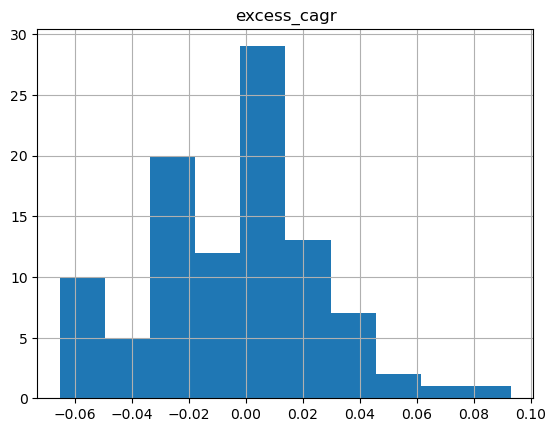

In [12]:
optimizer.plot('excess_cagr')

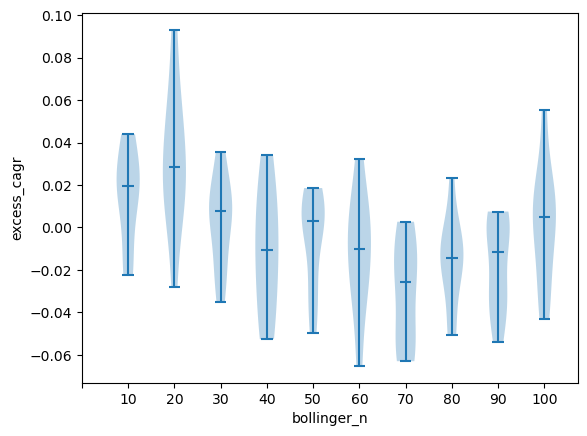

In [13]:
optimizer.plot('bollinger_n', 'excess_cagr')

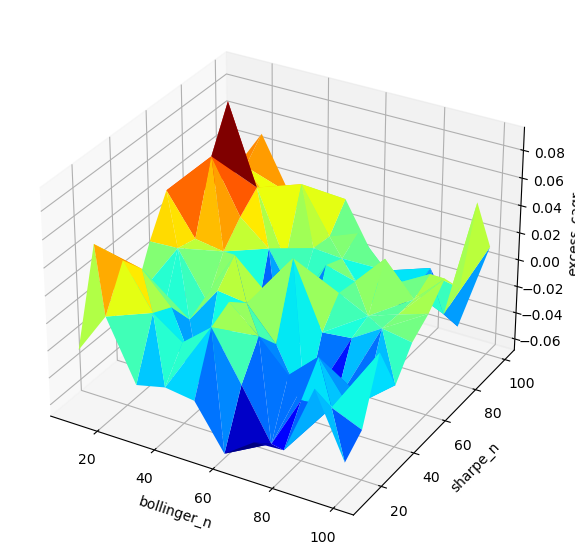

In [14]:
optimizer.plot('bollinger_n', 'sharpe_n', 'excess_cagr')

### 5.3 White Noise Preference Matrix

In [15]:
import pandas as pd
import numpy as np

from pypm import metrics, signals, data_io, simulation, optimization
from pypm.optimization import GridSearchOptimizer

from typing import List, Dict, Tuple, Callable

In [16]:
Performance = simulation.PortfolioHistory.PerformancePayload # Dict[str, float]

In [17]:
def bind_simulator(**sim_kwargs) -> Callable:
    """
    Create a simulator that uses white noise for the preference matrix
    """
    symbols: List[str] = data_io.get_all_symbols()
    prices: pd.DataFrame = data_io.load_eod_matrix(symbols)

    _bollinger: Callable = signals.create_bollinger_band_signal

    # Bollinger n is constant throughout
    bollinger_n = 20

    def _simulate(white_noise_test_id: int) -> Performance:
        
        signal = prices.apply(_bollinger, args=(bollinger_n,), axis=0)

        # Build a pile of noise in the same shape as the price data
        _noise = np.random.normal(loc=0, scale=1, size=prices.shape)
        _cols = prices.columns
        _index = prices.index
        preference = pd.DataFrame(_noise, columns=_cols, index=_index)

        simulator = simulation.SimpleSimulator(**sim_kwargs)
        simulator.simulate(prices, signal, preference)

        return simulator.portfolio_history.get_performance_metric_data()

    return _simulate

In [18]:
simulate = bind_simulator(initial_cash=10000, max_active_positions=5)

optimizer = GridSearchOptimizer(simulate)
optimizer.optimize(white_noise_test_id=range(1000))

print(optimizer.get_best('excess_cagr'))

Starting simulation ...
Simulated 1000 / 1000 .... 0s remaining (0.8s avg)         
Elapsed time: 800s
Done.
     white_noise_test_id  excess_cagr
948                  948     0.079643
294                  294     0.063466
237                  237     0.057552
162                  162     0.054856
187                  187     0.052135
..                   ...          ...
662                  662    -0.114568
443                  443    -0.117520
624                  624    -0.117559
711                  711    -0.125232
684                  684    -0.133986

[1000 rows x 2 columns]


In [19]:
optimizer.print_summary()

Summary statistics
                         count          mean           std          min  \
dollar_max_drawdown     1000.0   8288.036080  2.005602e+03  3932.261764   
percent_return          1000.0      1.060402  6.001322e-01    -0.216088   
cagr                    1000.0      0.071209  3.019852e-02    -0.024081   
sharpe_ratio            1000.0      0.364594  1.537662e-01    -0.122718   
spy_percent_return      1000.0      1.832527  2.599222e-14     1.832527   
jensens_alpha           1000.0     -0.000155  1.121064e-04    -0.000515   
final_cash              1000.0  20604.019137  6.001322e+03  7839.117135   
spy_cagr                1000.0      0.109904  1.749476e-15     0.109904   
excess_cagr             1000.0     -0.038695  3.019852e-02    -0.133986   
log_max_drawdown_ratio  1000.0      0.234017  3.599574e-01    -1.095178   
number_of_trades        1000.0   3106.195000  2.596002e+01  3021.000000   
volatility              1000.0      0.195474  3.640365e-03     0.186165   
averag

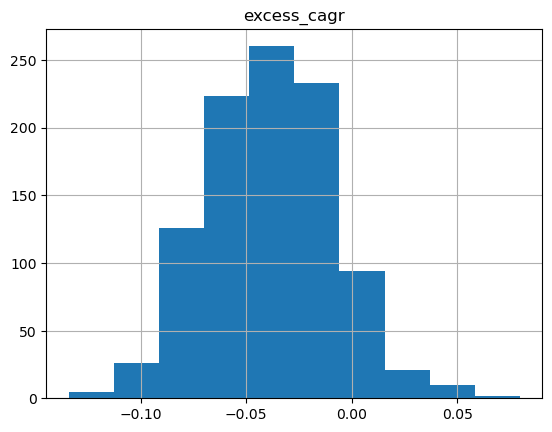

In [20]:
optimizer.plot('excess_cagr')

### 5.4 Bootstrap Simulated Preference Matrix

In [21]:
import pandas as pd
import numpy as np

from pypm import metrics, signals, data_io, simulation, optimization
from pypm.optimization import GridSearchOptimizer

from typing import List, Dict, Tuple, Callable

Performance = simulation.PortfolioHistory.PerformancePayload # Dict[str, float]

In [22]:
def bind_simulator(**sim_kwargs) -> Callable:
    """
    Create a simulator that uses white noise for the preference matrix
    """
    symbols: List[str] = data_io.get_all_symbols()
    prices: pd.DataFrame = data_io.load_eod_matrix(symbols)

    _bollinger: Callable = signals.create_bollinger_band_signal
    bollinger_n = 20

    returns = metrics.calculate_return_series(prices)
    sharpe_n = 20

    def bootstrap_rolling_sharpe_ratio(return_series: pd.Series) -> pd.Series:
        _series = return_series.iloc[1:]
        _series = _series.sample(n=return_series.shape[0], replace=True)
        _series.iloc[:1] = [np.nan]
        _series = pd.Series(_series.values, index=return_series.index)
        _windowed_series = _series.rolling(sharpe_n)
        return _windowed_series.mean() / _windowed_series.std()

    _sharpe: Callable = bootstrap_rolling_sharpe_ratio

    def _simulate(bootstrap_test_id: int) -> Performance:
        
        signal = prices.apply(_bollinger, args=(bollinger_n,), axis=0)
        preference = returns.apply(_sharpe, axis=0)

        simulator = simulation.SimpleSimulator(**sim_kwargs)
        simulator.simulate(prices, signal, preference)

        return simulator.portfolio_history.get_performance_metric_data()

    return _simulate

In [23]:
simulate = bind_simulator(initial_cash=10000, max_active_positions=5)

optimizer = GridSearchOptimizer(simulate)
optimizer.optimize(bootstrap_test_id=range(1000))

print(optimizer.get_best('excess_cagr'))

Starting simulation ...
Simulated 1000 / 1000 .... 0s remaining (0.5s avg)         
Elapsed time: 544s
Done.
     bootstrap_test_id  excess_cagr
485                485     0.119294
952                952     0.119127
113                113     0.111840
254                254     0.107373
265                265     0.101915
..                 ...          ...
624                624    -0.067285
697                697    -0.068219
516                516    -0.069483
807                807    -0.069670
108                108    -0.074255

[1000 rows x 2 columns]


In [24]:
optimizer.print_summary()

Summary statistics
                         count          mean           std           min  \
dollar_max_drawdown     1000.0   8610.799762  2.236704e+03   3700.521230   
percent_return          1000.0      2.184929  9.456088e-01      0.418856   
cagr                    1000.0      0.118793  3.213263e-02      0.035649   
sharpe_ratio            1000.0      0.635875  1.733591e-01      0.194958   
spy_percent_return      1000.0      1.832527  2.599222e-14      1.832527   
jensens_alpha           1000.0      0.000027  1.148848e-04     -0.000266   
final_cash              1000.0  31849.290864  9.456088e+03  14188.559360   
spy_cagr                1000.0      0.109904  1.749476e-15      0.109904   
excess_cagr             1000.0      0.008889  3.213263e-02     -0.074255   
log_max_drawdown_ratio  1000.0      0.763241  3.320453e-01     -0.215570   
number_of_trades        1000.0   1359.872000  2.872763e+01   1251.000000   
volatility              1000.0      0.187246  3.854455e-03      0.176

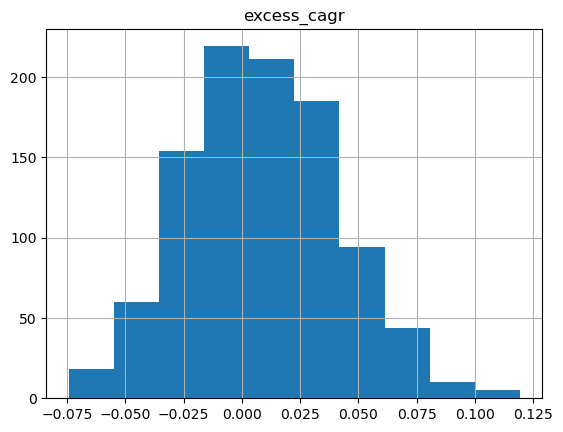

In [25]:
optimizer.plot('excess_cagr')